In [1]:
import torch
import torch.nn as nn

In [2]:
from torchvision import datasets, transforms

# Define a transform to normalize the data and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

# Download and load the MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)

In [29]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, leaky = 0.01):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(leaky),
            nn.Conv2d(hidden_dim , hidden_dim , kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(leaky),
            nn.Conv2d(hidden_dim, hidden_dim , kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(leaky),
            nn.Conv2d(hidden_dim , hidden_dim , kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(leaky),
            nn.Flatten(),
        )
        self.fc2 = nn.Linear(3136, output_dim)

    def forward(self, x):
        x = self.conv(x)
        x = self.fc2(x)
        # x = nn.functional.sigmoid(x)
        return x
    
# class Decoder(nn.Module):

In [30]:
enc = Encoder(input_dim=1, hidden_dim=64, output_dim=2).to('cuda')
x = torch.randn(1, 1, 28, 28).to('cuda')  # Example input tensor
# output = enc(x)
# print("Output shape:", output.shape)  # Should print the shape of the output tensor

from torchinfo import summary
summary(enc, (1,1,28,28), device='cuda')  # Print the model summary

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 3136]                 --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─LeakyReLU: 2-2                    [1, 64, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 64, 14, 14]           36,928
│    └─LeakyReLU: 2-4                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-5                       [1, 64, 7, 7]             36,928
│    └─LeakyReLU: 2-6                    [1, 64, 7, 7]             --
│    └─Conv2d: 2-7                       [1, 64, 7, 7]             36,928
│    └─LeakyReLU: 2-8                    [1, 64, 7, 7]             --
│    └─Flatten: 2-9                      [1, 3136]                 --
├─Linear: 1-2                            [1, 2]                    6,274
Total params: 117,698
Trainable params: 117,698
Non-trainable params:

In [26]:
# x.shape

In [33]:


class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, leaky = 0.01):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(output_dim, 3136)
        self.conv = nn.Sequential(
            
            # Reshape(-1, hidden_dim * 2, 16, 16),
            nn.ConvTranspose2d(input_dim, hidden_dim , kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(leaky),
            nn.ConvTranspose2d(hidden_dim, hidden_dim , kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(leaky),
            
            nn.ConvTranspose2d(hidden_dim , hidden_dim , kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(leaky),
            nn.ConvTranspose2d(hidden_dim , 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(leaky),
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 64, 7, 7)
        x = self.conv(x)
        x = nn.functional.sigmoid(x)    
        return x

In [34]:
summary(Decoder(input_dim=64, hidden_dim=64, output_dim=2).to('cuda'), (1, 2), device='cuda')  # Print the model summary

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [1, 1, 28, 28]            --
├─Linear: 1-1                            [1, 3136]                 9,408
├─Sequential: 1-2                        [1, 1, 28, 28]            --
│    └─ConvTranspose2d: 2-1              [1, 64, 7, 7]             36,928
│    └─LeakyReLU: 2-2                    [1, 64, 7, 7]             --
│    └─ConvTranspose2d: 2-3              [1, 64, 7, 7]             36,928
│    └─LeakyReLU: 2-4                    [1, 64, 7, 7]             --
│    └─ConvTranspose2d: 2-5              [1, 64, 14, 14]           36,928
│    └─LeakyReLU: 2-6                    [1, 64, 14, 14]           --
│    └─ConvTranspose2d: 2-7              [1, 1, 28, 28]            577
│    └─LeakyReLU: 2-8                    [1, 1, 28, 28]            --
Total params: 120,769
Trainable params: 120,769
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 11.32
Input size (MB): 0.00
Forw

In [35]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, output_dim)
        self.decoder = Decoder(hidden_dim , hidden_dim , output_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        # print(x.shape)
        decoded = self.decoder(encoded)
        return decoded

In [40]:
autoencoder = Autoencoder(input_dim=1, hidden_dim=64, output_dim=2).to('cuda')
summary(autoencoder, (1, 1, 28, 28), device='cuda')  # Print the model summary

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [1, 1, 28, 28]            --
├─Encoder: 1-1                           [1, 2]                    --
│    └─Sequential: 2-1                   [1, 3136]                 --
│    │    └─Conv2d: 3-1                  [1, 64, 28, 28]           640
│    │    └─LeakyReLU: 3-2               [1, 64, 28, 28]           --
│    │    └─Conv2d: 3-3                  [1, 64, 14, 14]           36,928
│    │    └─LeakyReLU: 3-4               [1, 64, 14, 14]           --
│    │    └─Conv2d: 3-5                  [1, 64, 7, 7]             36,928
│    │    └─LeakyReLU: 3-6               [1, 64, 7, 7]             --
│    │    └─Conv2d: 3-7                  [1, 64, 7, 7]             36,928
│    │    └─LeakyReLU: 3-8               [1, 64, 7, 7]             --
│    │    └─Flatten: 3-9                 [1, 3136]                 --
│    └─Linear: 2-2                       [1, 2]                    6,274

In [ ]:
from torch.utils.data import random_split, DataLoader

# Define the split sizes
train_size = int(0.8 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(mnist_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [42]:

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0005)
# Training the autoencoder
epochs = 200  # Number of epochs for training
    
for epoch in range(epochs):
    for data, _ in train_loader:
        data = data.to('cuda')
        optimizer.zero_grad()
        output = autoencoder(data)
        loss = nn.functional.mse_loss(output, data)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.10979873687028885
Epoch 2, Loss: 0.116000235080719
Epoch 3, Loss: 0.10831580311059952
Epoch 4, Loss: 0.1173040121793747
Epoch 5, Loss: 0.10627396404743195
Epoch 6, Loss: 0.11320386081933975
Epoch 7, Loss: 0.11243826895952225
Epoch 8, Loss: 0.10839948803186417
Epoch 9, Loss: 0.11539704352617264
Epoch 10, Loss: 0.060189057141542435
Epoch 11, Loss: 0.051073506474494934
Epoch 12, Loss: 0.04845587909221649
Epoch 13, Loss: 0.04664718732237816
Epoch 14, Loss: 0.0490368977189064
Epoch 15, Loss: 0.04527375102043152
Epoch 16, Loss: 0.044807981699705124
Epoch 17, Loss: 0.04178055748343468
Epoch 18, Loss: 0.04291572421789169
Epoch 19, Loss: 0.046612489968538284
Epoch 20, Loss: 0.04315045475959778
Epoch 21, Loss: 0.039879895746707916
Epoch 22, Loss: 0.04184161499142647
Epoch 23, Loss: 0.03853415697813034
Epoch 24, Loss: 0.03953186795115471
Epoch 25, Loss: 0.0466708168387413
Epoch 26, Loss: 0.03849957510828972
Epoch 27, Loss: 0.03954695910215378
Epoch 28, Loss: 0.038018640130758286


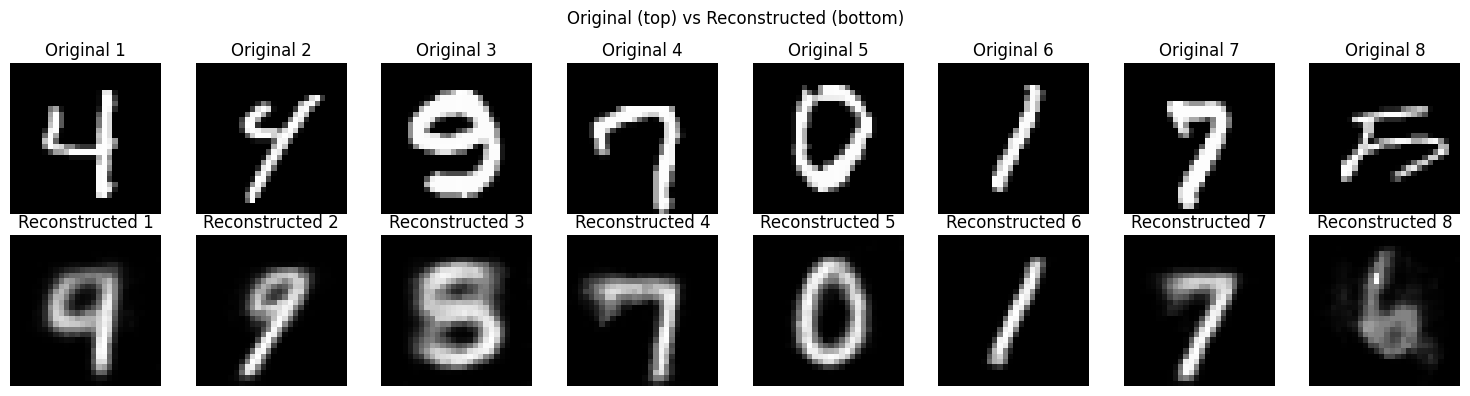

In [43]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    for data, _ in val_loader:
        data = data.to('cuda')
        res = autoencoder(data)
        break

# Move tensors to CPU and convert to numpy for visualization
original_images = data.cpu().numpy()
reconstructed_images = res.cpu().numpy()

# Plot original vs reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Original (top) vs Reconstructed (bottom)')

for i in range(8):
    # Original images
    axes[0, i].imshow(original_images[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')
    
    # Reconstructed images
    axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
    axes[1, i].set_title(f'Reconstructed {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()